# Logistic Regression

This logistic regression is based on the Beeler/Daw et al. 2010 paper.
Specifically:

dependent variable: binary choice of port (-1 or 1)

explanatory variables: 
1. the N previous rewards $ r_{t-N:t-1} $
2. the previous choice $c_{t-1}$ to capture a tendency to stay or switch
3. bias variable (1) to capture fixed, overall preference for either port

Note: this model only carries information about ports when it gets a reward. IE -1 = right reward, 1 = left reward, but 0 = no reward (for either side). Should compare models with this information vs. added information about the non-rewarded port choices. 

## 02/19/2017
I just ran the above code on the following data:
    
- `full_9010_02192017.csv`
- `full_8020_02192017.csv`
- `full_7030_02192017.csv`

Which were computed by compiling the following data:
- block range: exactly 50 rewards
- p(choose high Port) >= [p-0.1] where p = p(high Port)

Observations:
1. F1 for each condition pretty similar. ~0.82-0.85
2. pseudo-R2 also similar: ~0.64-0.69
3. For (1) and (2) maybe a slight trend that 90-10 had a better model, but not certain. 
4. For each condition, I tried adding in more ports (up to 3) into the past to see if it would help out. For all 3 conditions, decisions for t-N where 2 >= 2 had coefficients = 0. That is, the only non-zero beta for the ports was the most recent one. 

Next step: 


**Figures**

1. Logistic regression performs similarly across different conditions
    - x axis: 90-10,80-20,70-30
    - y axis: F1 score, pseudo-R2
2. Comparing model flexibility across different conditions
    - x axis: number of previous rewards included (i.e. parameters in model)
    - y axis: BIC
    - color: each condition
3. Knowing where the non-rewarded trials are:
    - what if you did the same regression, but instead you know where the non-rewarded trials are?
    - also, compare to adding in previous ports (or rewards in the above scenario) and compare

4. Comparing 'strategies' across conditions
    - train on 90-10, test on 80-20 (and all combinations)

5. Comparing 'strategies' across mice
    - train on one mouse:condition pair, and test on another mouse:condition pair (for the same condition)
    


In [1]:
import sys
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
import sklearn.linear_model
import sklearn.tree
%matplotlib inline 

## define function to do logistic regression and some basic evalutions

In [2]:
'''
I compiled the code above into a more compact function so I can cycle through different conditions/mice/etc 
as neccessary
'''

def logreg_and_eval(data,num_rewards=10,test_data=False):
    '''
    Perform Logistic Regression on a pandas dataframe of trials (from feature matrix)
    
    Inputs:
        - data: pandas dataframe of trials (from feature matrix)
    Outputs:
        - logreg: trained logistic regression model (from sklearn)
        - stats:  pandas dataframe with F1, pseudo-R2, and BIC scores from model
        - coeffs: beta coefficients from logreg
    
    '''
    from statsmodels.discrete.discrete_model import Logit
    
    port_features = []
    reward_features = []

    #change right port to -1 instead of 0
    for col in data:
        if '_Port' in col:
            data.loc[data[col] == 0,col] = -1
            port_features.append(col)
        elif '_Reward' in col:
            reward_features.append(col)

    #create new feature matrix
    data_new = data.copy()
    for i in range(len(port_features)):
        data_new[reward_features[i]] = data[reward_features[i]].values*data[port_features[i]].values
    
    
    #determine the features
    features = reward_features.copy()
    features = features[-1*num_rewards:] #only take the num of rewards specificied in the function
    features.append('1_Port') #append the last decision as a feature
    features.append('Decision') #finally append the decision so we can take it to predict later
    
    #final version of data
    data = data_new[features].copy() #this now just has the features we want and the decision we want to predict
    
    #do the same thing for the test data if it exists!
    if test_data is not False:
        for col in test_data:
            if '_Port' in col:
                test_data.loc[test_data[col] == 0,col] = -1

        #create new feature matrix
        data_test_new = test_data.copy()
        for i in range(len(port_features)):
            data_test_new[reward_features[i]] = test_data[reward_features[i]].values*test_data[port_features[i]].values
        
        data_test = data_test_new[features].copy()
    
    
        #set training and testing sets now
        x_train = data.iloc[:,:-1].values
        y_train = data.iloc[:,-1].values
        x_test = data_test.iloc[:,:-1].values
        y_test = data_test.iloc[:,-1].values
    
    #if there is no test data, then split up the data into training and testing
    else:
        #extract features and decisions
        x = data.iloc[:,:-1].values
        y = data.iloc[:,-1].values

        #split into training and testing
        n_trials = x.shape[0]
        shuf_inds = np.random.permutation(n_trials)
        split_ind = int(n_trials*0.7)

        x_train = x[shuf_inds[:split_ind],:]
        y_train = y[shuf_inds[:split_ind]]

        x_test = x[shuf_inds[split_ind:],:]
        y_test = y[shuf_inds[split_ind:]]
    
    '''
    Modeling
    '''
    
    #fit logistic regression
    logreg = sklearn.linear_model.LogisticRegressionCV()
    logreg.fit(x_train,y_train)
    
    #predict on testing set
    y_predict = logreg.predict(x_test)
    y_predict_proba = logreg.predict_proba(x_test)
    
    #model accuracy
    score = logreg.score(x_test,y_test)
    
    #calculating pseudo-R2 and BIC from statsmodel OLS
    model = Logit(y_train,x_train)
    rslt  = model.fit()

    #calc true switches
    y_test_switch = np.abs(np.diff(y_test))
    #calc model switches
    y_predict_switch = np.abs(np.diff(y_predict))
    acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict_switch,y_test_switch,confusion=False,disp=True)
    
    #extract coefficients
    coefs = logreg.coef_ #retrieve coefs
    coefs = np.append(coefs[0],logreg.intercept_) #add bias coef
    
    #create stats database to return
    d = {'pseudo-R2':rslt.prsquared,'F1':F1,'Accuracy':score,'BIC':rslt.bic,'negative loglikelihood':-1*rslt.llf}
    stats = pd.DataFrame(data=d,index=[0])
    features = features[:-1]
    features.append('Bias')
    
    coefs = pd.DataFrame(data=coefs.reshape(1,-1),columns=features)
    return logreg,stats,coefs

# Write here

In [3]:
data_90 = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/full_9010_02192017.csv',index_col=0)
data_80 = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/full_8020_02192017.csv',index_col=0)
data_70 = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/full_7030_02192017.csv',index_col=0)

datas = [data_70,data_80,data_90]
models = []

In [4]:
for i,d in enumerate(datas):
    
    for j in range(30):
        model_curr,stats_curr,coefs_curr = logreg_and_eval(d,num_rewards=7)
        models.append(models)

        if ((i == 0 and j == 0)):
            stats = stats_curr.copy()
            coefs = coefs_curr.copy()
        else:
            stats = stats.append(stats_curr)
            coefs = coefs.append(coefs_curr)

c = np.zeros(90)+70
c[30:] = 80
c[60:] = 90

stats.insert(0,'Condition',c)
coefs.insert(0,'Condition',c)

Optimization terminated successfully.
         Current function value: 0.235684
         Iterations 8
          Predicted NO  Predicted YES
True NO         2277.0          471.0
True YES         455.0         2153.0

F1: 0.823

Accuracy on class 0: 0.83
Accuracy on class 1: 0.83

Optimization terminated successfully.
         Current function value: 0.235820
         Iterations 8
          Predicted NO  Predicted YES
True NO         2239.0          454.0
True YES         453.0         2210.0

F1: 0.830

Accuracy on class 0: 0.83
Accuracy on class 1: 0.83

Optimization terminated successfully.
         Current function value: 0.239389
         Iterations 8
          Predicted NO  Predicted YES
True NO         2241.0          448.0
True YES         432.0         2235.0

F1: 0.836

Accuracy on class 0: 0.83
Accuracy on class 1: 0.84

Optimization terminated successfully.
         Current function value: 0.239189
         Iterations 8
          Predicted NO  Predicted YES
True NO         2

# Comparing beta coefficients across conditions

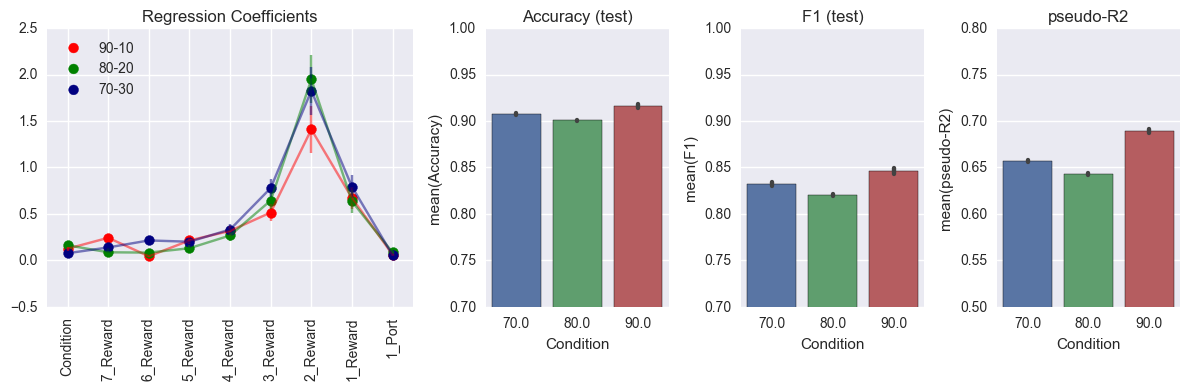

In [5]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(1,4,width_ratios=[2,1,1,1])

plt.subplot(gs[0])
plt.errorbar(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 90].iloc[:,1:].mean(),
             yerr= coefs[coefs['Condition'] == 90].iloc[:,1:].mean() / np.sqrt(np.sum(coefs['Condition'] == 90)),
             color='red',alpha=0.5)
plt.errorbar(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 80].iloc[:,1:].mean(),
             yerr= coefs[coefs['Condition'] == 90].iloc[:,1:].mean() / np.sqrt(np.sum(coefs['Condition'] == 90)),
             color='green',alpha=0.5)
plt.errorbar(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 70].iloc[:,1:].mean(),
             yerr= coefs[coefs['Condition'] == 90].iloc[:,1:].mean() / np.sqrt(np.sum(coefs['Condition'] == 90)),
             color='navy',alpha=0.5)

plt.scatter(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 90].iloc[:,1:].mean(),
            color='red',label='90-10',s=50)
plt.scatter(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 80].iloc[:,1:].mean(),
            color='green',label='80-20',s=50)
plt.scatter(np.arange(coefs.shape[1]-1),coefs[coefs['Condition'] == 70].iloc[:,1:].mean(),
            color='navy',label='70-30',s=50)

plt.legend(loc='upper left')
plt.xticks(np.arange(coefs.shape[1]),coefs.columns.values,rotation='vertical')
plt.xlim(-0.5,8.5)
plt.title('Regression Coefficients')

plt.subplot(gs[1])
sns.barplot(x='Condition',y='Accuracy',data=stats)
plt.title('Accuracy (test)')
plt.ylim(0.7,1)

plt.subplot(gs[2])
sns.barplot(x='Condition',y='F1',data=stats)
plt.title('F1 (test)')
plt.ylim(0.7,1)

plt.subplot(gs[3])
sns.barplot(x='Condition',y='pseudo-R2',data=stats)
plt.title('pseudo-R2')
plt.ylim(0.5,0.8)

plt.tight_layout()

# Training / testing on different conditions

### 1. Train on 90-10, test on 80-20 and 70-30

In [6]:
for i,d in enumerate([data_90,data_80,data_70]):
    
    if i == 0:
        model,stats,coefs = logreg_and_eval(d)
    else:
        model,stats_curr,coefs_curr = logreg_and_eval(data_90,test_data = d)
        
        stats = stats.append(stats_curr)
        coefs = coefs.append(coefs_curr)

stats_90 = stats.drop(['BIC','negative loglikelihood','pseudo-R2'],axis=1)

Optimization terminated successfully.
         Current function value: 0.220464
         Iterations 7
          Predicted NO  Predicted YES
True NO         1373.0          222.0
True YES         248.0         1392.0

F1: 0.856

Accuracy on class 0: 0.86
Accuracy on class 1: 0.85

Optimization terminated successfully.
         Current function value: 0.216107
         Iterations 8
          Predicted NO  Predicted YES
True NO        41098.0         2825.0
True YES        4156.0          765.0

F1: 0.180

Accuracy on class 0: 0.94
Accuracy on class 1: 0.16

Optimization terminated successfully.
         Current function value: 0.216107
         Iterations 8
          Predicted NO  Predicted YES
True NO        15081.0         1118.0
True YES        1344.0          312.0

F1: 0.202

Accuracy on class 0: 0.93
Accuracy on class 1: 0.19



In [7]:
stats_90['Testing Condition'] = [90,80,70]
stats_90

,Accuracy,F1,Testing Condition
0,0.920272,0.855562,90
0,0.900993,0.179767,80
0,0.907482,0.202203,70


So this is interesting - accuracy stays pretty much the same across conditions, but F1 goes way down. And if we take a look at the confusion tables above, we can see it is because the accuracy on the switches went down (and accuracy on stays went up. 

### 2. Train on 80-20

In [8]:
for i,d in enumerate([data_80,data_90,data_70]):
    
    if i == 0:
        model,stats,coefs = logreg_and_eval(d)
    else:
        model,stats_curr,coefs_curr = logreg_and_eval(data_80,test_data = d)
        
        stats = stats.append(stats_curr)
        coefs = coefs.append(coefs_curr)

stats_80 = stats.drop(['BIC','negative loglikelihood','pseudo-R2'],axis=1)

stats_80['Testing Condition'] = [80,90,70]
stats_80

Optimization terminated successfully.
         Current function value: 0.249563
         Iterations 8
          Predicted NO  Predicted YES
True NO         6071.0         1309.0
True YES        1269.0         6004.0

F1: 0.823

Accuracy on class 0: 0.82
Accuracy on class 1: 0.83

Optimization terminated successfully.
         Current function value: 0.247334
         Iterations 8
          Predicted NO  Predicted YES
True NO         9419.0          444.0
True YES         794.0          128.0

F1: 0.171

Accuracy on class 0: 0.95
Accuracy on class 1: 0.14

Optimization terminated successfully.
         Current function value: 0.247334
         Iterations 8
          Predicted NO  Predicted YES
True NO        15051.0         1148.0
True YES        1332.0          324.0

F1: 0.207

Accuracy on class 0: 0.93
Accuracy on class 1: 0.20



,Accuracy,F1,Testing Condition
0,0.902689,0.823255,80
0,0.918598,0.171352,90
0,0.907706,0.207161,70


### 3. Train on 70-30

In [9]:
for i,d in enumerate([data_70,data_80,data_90]):
    
    if i == 0:
        model,stats,coefs = logreg_and_eval(d)
    else:
        model,stats_curr,coefs_curr = logreg_and_eval(data_70,test_data = d)
        
        stats = stats.append(stats_curr)
        coefs = coefs.append(coefs_curr)

stats_70 = stats.drop(['BIC','negative loglikelihood','pseudo-R2'],axis=1)

stats_70['Testing Condition'] = [70,80,90]
stats_70

Optimization terminated successfully.
         Current function value: 0.236742
         Iterations 8
          Predicted NO  Predicted YES
True NO         2218.0          450.0
True YES         442.0         2246.0

F1: 0.834

Accuracy on class 0: 0.83
Accuracy on class 1: 0.84

Optimization terminated successfully.
         Current function value: 0.238406
         Iterations 8
          Predicted NO  Predicted YES
True NO        41013.0         2910.0
True YES        4125.0          796.0

F1: 0.185

Accuracy on class 0: 0.93
Accuracy on class 1: 0.16

Optimization terminated successfully.
         Current function value: 0.238406
         Iterations 8
          Predicted NO  Predicted YES
True NO         9407.0          456.0
True YES         788.0          134.0

F1: 0.177

Accuracy on class 0: 0.95
Accuracy on class 1: 0.15



,Accuracy,F1,Testing Condition
0,0.906664,0.834324,70
0,0.900727,0.184537,80
0,0.917764,0.177249,90


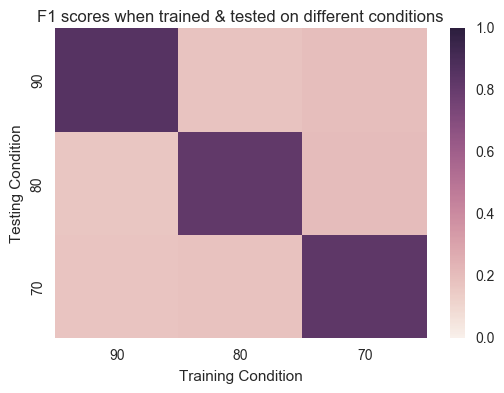

In [10]:
f1s = np.vstack((stats_90['F1'].values,
               stats_80['F1'].values[[1,0,2]],
               stats_70['F1'].values[[2,1,0]]))
sns.heatmap(f1s,vmin=0,vmax=1)
plt.xticks([0.5,1.5,2.5],['90','80','70'])
plt.yticks([0.5,1.5,2.5],['70','80','90'])
plt.ylabel('Testing Condition')
plt.xlabel('Training Condition')
plt.title('F1 scores when trained & tested on different conditions')

So if this is right, it means that the rules are different - what predicts a switch in 90-10 does not predict a switch in 80-20. But since most of the trials follow the last one, the accuracy doesn't drop very much. So it appears to be working fine, even though it is not. 

Can the difference be explained in the small differences in beta coefficient values? It must be ... what else is there? They seem similar enough that I'm surprised it makes such a difference. 

Let's go on to train and test on separate mice:

# Train/test on separate mice

First let's take a quick look at the mice's performances - specifically just at p(choose high P port):

In [11]:
data_90.insert(0,'Condition',0.9)
data_80.insert(0,'Condition',0.8)
data_70.insert(0,'Condition',0.7)

In [12]:
all_data = data_90.append(data_80)
all_data = all_data.append(data_70)
all_data.shape

(77487, 51)

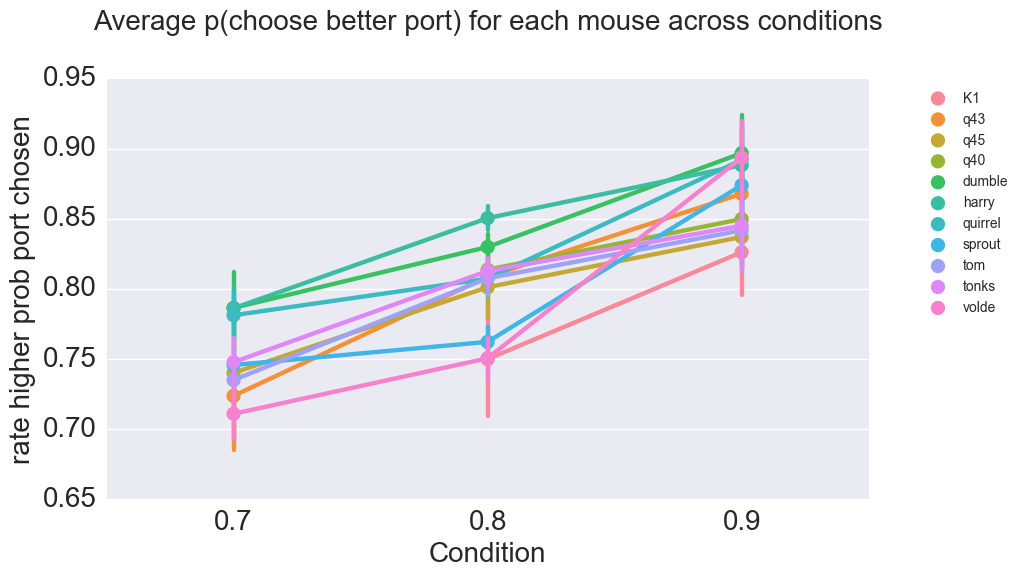

In [13]:
sns.factorplot(x='Condition',y='Higher p port',hue='Mouse ID',data = all_data,legend=False,size=5,aspect=1.7)
plt.legend(bbox_to_anchor=(1.2,1))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Condition',fontsize=20)
plt.ylabel('rate higher prob port chosen',fontsize=20)
plt.title('Average p(choose better port) for each mouse across conditions',fontsize=20,x=0.5,y=1.1)

Okay, so based on this. Let's start with 80-20, and do a few different comparisons. 

1. Start by training with harry, and testing on all the others. 
2. Then try training on volde, testing on all others. 
3. Finally train on someone in the middle - like Tom or q45, and test on others

In [14]:
mice = np.unique(data_80['Mouse ID'].values)

In [15]:
mice

array(['K1', 'dumble', 'harry', 'q40', 'q43', 'q45', 'quirrel', 'sprout',
       'tom', 'tonks', 'volde'], dtype=object)

In [16]:
'''
Train on HARRY
'''
d_train = data_80[data_80['Mouse ID'] == 'harry'].copy()

for i,mouse in enumerate(mice):
    d_test = data_80[data_80['Mouse ID'] == mouse].copy()
    
    if i == 0:
        model,stats,coefs = logreg_and_eval(d_train,test_data = d_test)
    else:
        model,stats_curr,coefs_curr = logreg_and_eval(d_train,test_data = d_test)
        
        stats = stats.append(stats_curr)
        coefs = coefs.append(coefs_curr)

stats = stats.drop(['BIC','negative loglikelihood','pseudo-R2'],axis=1)

stats['Test Mouse'] = mice
stats


Optimization terminated successfully.
         Current function value: 0.162050
         Iterations 9
          Predicted NO  Predicted YES
True NO          307.0           31.0
True YES          70.0           11.0

F1: 0.179

Accuracy on class 0: 0.91
Accuracy on class 1: 0.14

Optimization terminated successfully.
         Current function value: 0.162050
         Iterations 9
          Predicted NO  Predicted YES
True NO         5650.0          350.0
True YES         510.0           82.0

F1: 0.160

Accuracy on class 0: 0.94
Accuracy on class 1: 0.14

Optimization terminated successfully.
         Current function value: 0.162050
         Iterations 9
          Predicted NO  Predicted YES
True NO         6057.0          257.0
True YES         385.0           64.0

F1: 0.166

Accuracy on class 0: 0.96
Accuracy on class 1: 0.14

Optimization terminated successfully.
         Current function value: 0.162050
         Iterations 9
          Predicted NO  Predicted YES
True NO         1

,Accuracy,F1,Test Mouse
0,0.833333,0.178862,K1
0,0.911270,0.160156,dumble
0,0.937020,0.166234,harry
0,0.910458,0.123810,q40
0,0.911908,0.173028,q43
0,0.856916,0.168285,q45
0,0.915041,0.132999,quirrel
0,0.853188,0.167862,sprout
0,0.896204,0.198675,tom
0,0.904016,0.132771,tonks


In [55]:
'''
TROUBLE SHOOTING
'''
data = data_80.copy()
data_test = False
num_rewards = 10


from statsmodels.discrete.discrete_model import Logit

port_features = []
reward_features = []

#change right port to -1 instead of 0
for col in data:
    if '_Port' in col:
        data.loc[data[col] == 0,col] = -1
        port_features.append(col)
    elif '_Reward' in col:
        reward_features.append(col)

#create new feature matrix
data_new = data.copy()
for i in range(len(port_features)):
    data_new[reward_features[i]] = data[reward_features[i]].values*data[port_features[i]].values


#determine the features
features = reward_features.copy()
features = features[-1*num_rewards:] #only take the num of rewards specificied in the function
features.append('1_Port') #append the last decision as a feature
features.append('Decision') #finally append the decision so we can take it to predict later

#final version of data
data = data_new[features].copy() #this now just has the features we want and the decision we want to predict

In [26]:
data.head(2)

,10_Reward,9_Reward,8_Reward,7_Reward,6_Reward,5_Reward,4_Reward,3_Reward,2_Reward,1_Reward,1_Port,Decision
0,-1.0,-1.0,-1.0,-1.0,-0.0,-0.0,0.0,0.0,0.0,-1.0,-1.0,0.0
1,-1.0,-1.0,-1.0,-0.0,-0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0.0


In [56]:
#do the same thing for the test data if it exists!
if data_test is not False:
    print('take it all')
    for col in data_test:
        if '_Port' in col:
            data_test.loc[data_test[col] == 0,col] = -1

    #create new feature matrix
    data_test_new = data_test.copy()
    
    for i in range(len(port_features)):
        data_test_new[reward_features[i]] = data_test[reward_features[i]].values*data_test[port_features[i]].values

    data_test = data_test_new[features].copy()


    #set training and testing sets now
    x_train = data.iloc[:,:-1].values
    y_train = data.iloc[:,-1].values
    x_test = data_test.iloc[:,:-1].values
    y_test = data_test.iloc[:,-1].values

#if there is no test data, then split up the data into training and testing
elif data_test is False:
    print("everyday I'm shuffling")
    #extract features and decisions
    x = data.iloc[:,:-1].values
    y = data.iloc[:,-1].values

    #split into training and testing
    n_trials = x.shape[0]
    shuf_inds = np.random.permutation(n_trials)
    split_ind = int(n_trials*0.7)

    x_train = x[shuf_inds[:split_ind],:]
    y_train = y[shuf_inds[:split_ind]]

    x_test = x[shuf_inds[split_ind:],:]
    y_test = y[shuf_inds[split_ind:]]
else:
    print('Something effed up')

everyday I'm shuffling


In [29]:
data_test.head(2)

,10_Reward,9_Reward,8_Reward,7_Reward,6_Reward,5_Reward,4_Reward,3_Reward,2_Reward,1_Reward,1_Port,Decision
0,-1.0,-1.0,-1.0,-1.0,-0.0,-0.0,0.0,0.0,0.0,-1.0,-1.0,0.0
1,-1.0,-1.0,-1.0,-0.0,-0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0.0


In [57]:
'''
Modeling
'''

#fit logistic regression
logreg = sklearn.linear_model.LogisticRegressionCV()
logreg.fit(x_train,y_train)

#predict on testing set
y_predict = logreg.predict(x_test)
y_predict_proba = logreg.predict_proba(x_test)

#model accuracy
score = logreg.score(x_test,y_test)

#calculating pseudo-R2 and BIC from statsmodel OLS
model = Logit(y_train,x_train)
rslt  = model.fit()

#calc true switches
y_test_switch = np.abs(np.diff(y_test))
#calc model switches
y_predict_switch = np.abs(np.diff(y_predict))
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict_switch,y_test_switch,confusion=False,disp=True)

#extract coefficients
coefs = logreg.coef_ #retrieve coefs
coefs = np.append(coefs[0],logreg.intercept_) #add bias coef

#create stats database to return
d = {'pseudo-R2':rslt.prsquared,'F1':F1,'Accuracy':score,'BIC':rslt.bic,'negative loglikelihood':-1*rslt.llf}
stats = pd.DataFrame(data=d,index=[0])
features = features[:-1]
features.append('Bias')

coefs = pd.DataFrame(data=coefs.reshape(1,-1),columns=features)

Optimization terminated successfully.
         Current function value: 0.248000
         Iterations 8
          Predicted NO  Predicted YES
True NO         6067.0         1328.0
True YES        1254.0         6004.0

F1: 0.823

Accuracy on class 0: 0.82
Accuracy on class 1: 0.83



In [58]:
np.sum(y_test_switch)

7258.0

In [66]:
data_80[data_80['Decision'] == 0]['Decision'].shape[0]

23254

In [67]:
data_80[data_80['Decision'] == 1]['Decision'].shape[0]

25591

In [54]:
logreg.fit(x_train,y_train)
y_pred = logreg.predict(x_train)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(np.abs(np.diff(y_pred)),np.abs(np.diff(y_train)),confusion=False,disp=True)

          Predicted NO  Predicted YES
True NO        40992.0         2931.0
True YES        4126.0          795.0

F1: 0.184

Accuracy on class 0: 0.93
Accuracy on class 1: 0.16



In [51]:
y_predict = logreg.predict(x_test)

In [52]:
acc_pos,acc_neg,F1=sf.score_both_and_confuse(np.abs(np.diff(y_predict)),np.abs(np.diff(y_test)),confusion=False,disp=True)

          Predicted NO  Predicted YES
True NO        40992.0         2931.0
True YES        4126.0          795.0

F1: 0.184

Accuracy on class 0: 0.93
Accuracy on class 1: 0.16



In [42]:
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict,y_test,confusion=False,disp=True)

          Predicted NO  Predicted YES
True NO        20768.0         2486.0
True YES        2324.0        23267.0

F1: 0.906

Accuracy on class 0: 0.89
Accuracy on class 1: 0.91



In [46]:
np.sum(np.abs(y_predict - y_test))

4810.0

In [48]:
np.abs(np.diff(y_predict))

array([ 0.,  0.,  0., ...,  1.,  1.,  1.])

In [19]:
sf.score_both_and_confuse(s_pred,s_true,confusion=False,disp=True)

NameError: name 's_true' is not defined

In [ ]:
x_train.shape

In [ ]:
np.sum(y_test - y_train)

In [ ]:
y_train.sum()